# Iowa Liquor Sales Forecast (Walkthrough)

This notebook goes through the steps necessary to train and forecast the
timeseries models that predict future sales of different liquors for the
state of Iowa.

## Before You Begin

To run this notebook, please make sure you have installed on your Python environment
the `iowa_forecast` package. To install the `iowa_forecast` package, execute the
following command from the project root directory (`"iowa_sales_forecast"`):

```console
pip install -e .
```

The above command will install the `iowa_forecast` package in development 
mode and the necessary dependencies defined inside the files
[pyproject.toml](../pyproject.toml) and [requirements.txt](../requirements.txt).

## Running the Whole Process

Optionally, you can run the entire training/forecasting process by executing 
the script [train_model_and_forecast_sales.py](../pipelines/train_model_and_forecast_sales.py):

```console
# Assuming you're on the project root directory:
python pipelines/train_model_and_forecast_sales.py
```

## Import Necessary Libraries

In [18]:
from __future__ import annotations

import os
from pathlib import Path

import pandas as pd
import seaborn as sns
from google.cloud.bigquery import Client
from iowa_forecast.load_data import (create_future_data,
                                     create_future_feature_tables,
                                     get_training_data)
from iowa_forecast.ml_eval import (explain_model,
                                   multi_evaluate_predictions)
from iowa_forecast.ml_train import create_models_for_items, train_arima_models
from iowa_forecast.plots import plot_historical_and_forecast
from iowa_forecast.utils import (create_bigquery_table_from_pandas,
                                 create_dataset_if_not_found)

### Load BigQuery Magic Functions

In [9]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Set Notebook Package Configurations

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
sns.set_theme()

## Define Notebook Parameters

The next cell defines the variables needed to initialize BigQuery client,
and the start and end dates of the train, test data.

In [16]:
how_to_set_environment_variables_message = (
    "To set environment variables:\n"
    " - Windows: Use the `set` command in the Command Prompt:\n"
    "   ```\n"
    """   echo 'export GOOGLE_APPLICATION_CREDENTIALS="/path/to/your/credentials.json"' >> /etc/profile && source /etc/profile"""
    "   ```\n"
    " - macOS/Linux: Identify which shell you're using by running the "
    "command `echo $SHELL`. Then depending on whether you're using zsh or "
    "bash, execute the command in the terminal:\n"
    "- For `zsh`:\n"
    "   ```\n"
    """   echo 'export GOOGLE_APPLICATION_CREDENTIALS="/path/to/your/credentials.json"' >> ~/.zshrc && source ~/.zshrc\n"""
    "   ```\n"
    "- For `bash`:\n"
    "   ```\n"
    """   echo 'export GOOGLE_APPLICATION_CREDENTIALS="/path/to/your/credentials.json"' >> ~/.bash_profile && source ~/.bash_profile\n"""
    "   ```\n"
)

PROJECT_ID = os.environ.get("PROJECT_ID", "iowa-liquor-sales-forecast-v3")
DATASET_NAME = os.environ.get("DATASET_NAME", "bqmlforecast")
GOOGLE_APPLICATION_CREDENTIALS = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS", "../iowa-sales-forecast-service-account.json")

if not any([PROJECT_ID, GOOGLE_APPLICATION_CREDENTIALS]):
    raise EnvironmentError(
        "The GOOGLE_APPLICATION_CREDENTIALS and PROJECT_ID environment "
        "variables are not set.\nPlease make sure that you have set at least "
        "one of these environment variables or specify them manually.\n"
        "The GOOGLE_APPLICATION_CREDENTIALS should contain the path of your "
        "Google Cloud credentials JSON file.\n"
        "For more information, see: https://cloud.google.com/docs/authentication/getting-started\n\n"
        "Additional context: to generate a new Google Cloud credentials JSON "
        "file, you need to create a service account in your Google Cloud Project, then\n"
        "export the service account credentials as a JSON file.\n"
        "Afterward, add the filepath of the downloaded"
        "JSON credentials to your environment variables.\n"
        "To create a new service account, go to: "
        "https://console.cloud.google.com/iam-admin/serviceaccounts\n\n"
        f"{how_to_set_environment_variables_message}"
    )

client_kwargs = {}
if isinstance(PROJECT_ID, str):
    client_kwargs["project"] = PROJECT_ID
if isinstance(GOOGLE_APPLICATION_CREDENTIALS, str):
    if not Path(GOOGLE_APPLICATION_CREDENTIALS).is_file():
        raise FileNotFoundError(
            "The specified GOOGLE_APPLICATION_CREDENTIALS file at "
            f"'{GOOGLE_APPLICATION_CREDENTIALS}' was not found.\n"
            "Please verify the file path and ensure that the file exists.\n"
            "Make sure you have correctly set the GOOGLE_APPLICATION_CREDENTIALS "
            "environment variable to point to the correct JSON credentials file.\n\n"
            f"{how_to_set_environment_variables_message}\n"
            "For more information, see: https://cloud.google.com/docs/authentication/getting-started\n"
        )
    client_kwargs["client_options"] = {"credentials_file": GOOGLE_APPLICATION_CREDENTIALS}

client = Client(**client_kwargs)

END_DATE = pd.Timestamp.today() - pd.DateOffset(days=14)
START_DATE = END_DATE - pd.DateOffset(years=3)

TEST_START_DATE = END_DATE + pd.DateOffset(days=1)

END_DATE = END_DATE.strftime("%Y-%m-%d")
START_DATE = START_DATE.strftime("%Y-%m-%d")
TEST_START_DATE = TEST_START_DATE.strftime("%Y-%m-%d")
HORIZON = 30

## Create a new dataset if it doesn't already exist

The function `create_dataset_if_not_found` creates a new dataset with the name
specified if it doesn't already exist.

In [14]:
create_dataset_if_not_found(client, dataset_name=DATASET_NAME)

Created dataset 'bqmlforecast'.


## Create the Train and Test Tables

Next, we'll create the train and test tables using the `get_training_data`
function.

The `get_training_data` function allows us to specify the starting and ending 
dates to use when the dataset. Therefore, by specifying these parameters,
we can create the training and test tables using the same function.
Additionally, this function creates or updates the created tables to BigQuery.

> **Note:** when creating the test dataset, we specify the list of items that
> exist in the training data so that both dataframes include information
> about the same items.

In [15]:
df_train = get_training_data(
    client,
    table_name=f"{DATASET_NAME}.training_data",
    start_date=START_DATE,
    end_date=END_DATE,
)

items_list = df_train.groupby("item_name")["total_amount_sold"].sum().sort_values(ascending=False).index.to_list()

# When `end_date` is not specified, the function uses today's date as the
# default value for the parameter.
df_test = get_training_data(client, start_date=TEST_START_DATE, table_name="bqmlforecast.test_data", items_list=items_list)

I0000 00:00:1723209193.141396 1314006 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


I0000 00:00:1723209205.081498 1314006 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


The above code generates two `pandas.DataFrame` objects each containing the 
following columns:

* **`date`:**
    * **Description:** The specific date for each record. It represents the date
      on which the sales data was recorded.
* **`item_name`:**
    * **Description:** The name or description of the item being sold. This is
      derived from the `item_description` field in the original Iowa Liquor
      sales data.
* **`total_amount_sold` (TARGET):**
    * **Description:** The total number of bottles sold on the specific date for
      the corresponding item. This is the sum of `bottles_sold` aggregated per day.
* **`avg_bottle_price`:**
    * **Description:** The average retail price of a bottle for the item on the
      specific date. This is the average of `state_bottle_retail` prices for
      that item.
* **`total_volume_sold_liters`:**
    * **Description:** The total volume of the item sold in liters on the
      specific date. This is calculated as the sum of `volume_sold_liters` for
      each day.
* **`avg_bottle_cost`:** 
   * **Description:** The average cost per bottle for the item on the
     specific date. This value is derived from the `state_bottle_cost` column
     in the sales data and represents the average cost at which the bottles
     were purchased by the retailer.

* **`day_of_week`:** 
   * **Description:** The day of the week for the specific date, where 1
     represents Sunday, 2 represents Monday, and so on. This is extracted
     using the `DAYOFWEEK` function.

* **`week_of_year`:** 
   * **Description:** The week number within the year for the specific date.
     This is extracted using the `WEEK` function.

* **`month`:** 
   * **Description:** The month of the year for the specific date. This is
     extracted using the `MONTH` function.

* **`year`:** 
    * **Description:** The year for the specific date. This is extracted
      using the `YEAR` function.

* **`ma3_total_volume_sold_liters`:** 
    * **Description:** The 3-day moving average of the total volume of the
      item sold in liters. This is calculated as the average of the
     `total_volume_sold_liters` over the current and preceding two days.

* **`ma3_avg_bottle_price`:** 
    * **Description:** The 3-day moving average of the average retail price
      of a bottle for the item. This is calculated as the average of the
     `avg_bottle_price` over the current and preceding two days.

* **`ma7_total_volume_sold_liters`:** 
    * **Description:** The 7-day moving average of the total volume of the
      item sold in liters. This is calculated as the average of the
     `total_volume_sold_liters` over the current and preceding six days.

* **`ma7_avg_bottle_price`:** 
    * **Description:** The 7-day moving average of the average retail price
      of a bottle for the item. This is calculated as the average of the
     `avg_bottle_price` over the current and preceding six days.

* **`ma30_total_volume_sold_liters`:** 
    * **Description:** The 30-day moving average of the total volume of the
      item sold in liters. This is calculated as the average of the
     `total_volume_sold_liters` over the current and preceding 29 days.

* **`ma30_avg_bottle_price`:** 
    * **Description:** The 30-day moving average of the average retail price
      of a bottle for the item. This is calculated as the average of the
     `avg_bottle_price` over the current and preceding 29 days.

* **`temperature`:** 
    * **Description:** The average temperature recorded on the specific date
      across various weather stations in Iowa. This is derived from the NOAA
      Global Surface Summary of Day (GSOD) data.

* **`rainfall`:** 
    * **Description:** The average amount of rainfall (in inches) recorded on
      the specific date across various weather stations in Iowa. This value
      is adjusted to replace any missing or erroneous data with zero.

* **`snowfall`:** 
    * **Description:** The average amount of snowfall (in inches) recorded on
      the specific date across various weather stations in Iowa. Similar to
      rainfall, missing or erroneous data is replaced with zero.

* **`lag_1_total_volume_sold_liters`:** 
    * **Description:** The total volume of the item sold in liters on the
     previous day (lagged by 1 day). This feature helps capture short-term
     trends in sales volume.

* **`lag_7_total_volume_sold_liters`:** 
    * **Description:** The total volume of the item sold in liters seven days
       prior (lagged by 7 days). This feature helps capture weekly seasonality
       in sales volume.


## Feature ARIMA Models

Since we don't have our model's features values during forecast, we need to 
somehow estimate their values and use these estimates to predict future sales.
The following code trains univariate ARIMA models and creates tables with
predicted values for each of our "base" features.

> **Note:** Our final model contains additional features but they are all
> subproducts of these three columns defined inside the `columns` list.

In [ ]:
columns = ["avg_bottle_price", "avg_bottle_cost", "total_volume_sold_liters"]
train_arima_models(
    client,
    columns,
    model=f"{PROJECT_ID}.{DATASET_NAME}.arima_model",
    train_table_name=f"{PROJECT_ID}.{DATASET_NAME}.training_data",
    test_table_name=f"{PROJECT_ID}.{DATASET_NAME}.test_data",
    model_metrics_table_name=f"{PROJECT_ID}.{DATASET_NAME}.arima_model_metrics",
    time_series_timestamp_col="date",
    time_series_id_col="item_name",
    confidence_level=0.9,
    horizon=HORIZON,
)
create_future_feature_tables(
    client,
    columns=columns,
    model=f"{PROJECT_ID}.{DATASET_NAME}.arima_model",
    table_base_name=f"{PROJECT_ID}.{DATASET_NAME}.forecast",
    confidence_level=0.9,
    horizon=HORIZON,
)

Output()

## Create Table for Future Sales Predictions

Next we'll create/update a table inside BigQuery with future dates and the 
predicted values of our features from our trained ARIMA models.

In [ ]:
create_future_data(
    client=client,
    train_table_name=f"{PROJECT_ID}.{DATASET_NAME}.training_data",
    test_table_name=f"{PROJECT_ID}.{DATASET_NAME}.test_data",
    forecast_table_name=f"{PROJECT_ID}.{DATASET_NAME}.future_forecast_data",
    horizon=HORIZON,
    dataset_id=DATASET_NAME,
)

## Train Sales Forecasting Models

The function `create_models_for_items` trains a multivariate ARIMA model for each `'item_name'` specified in the `items_list` parameter.
By default the models are saved as `'bqmlforecast.arima_plus_xreg_model_<NAME OF THE ITEM>'`. For example: `bqmlforecast.arima_plus_xreg_model_black_velvet`.

In [ ]:
create_models_for_items(client, items_list, max_items=4, clean_spikes_and_dips=True)

## Forecast Future Sales and Evaluate the Models

Output()

I0000 00:00:1723079439.210618  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723079442.664537  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723079446.244555  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723079449.490618  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723079452.582544  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723079456.001371  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723079459.265723  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723079462.270139  512714 check_gcp_

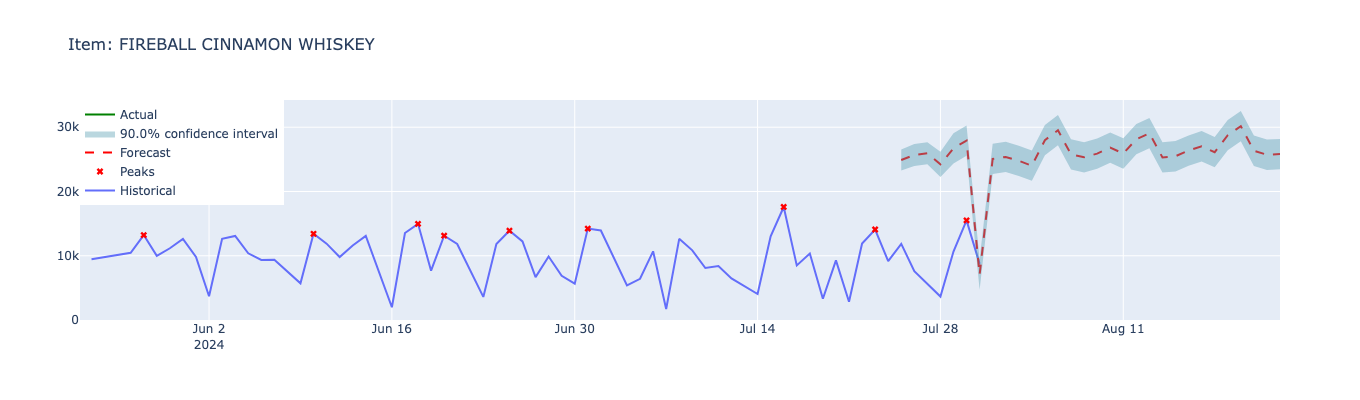

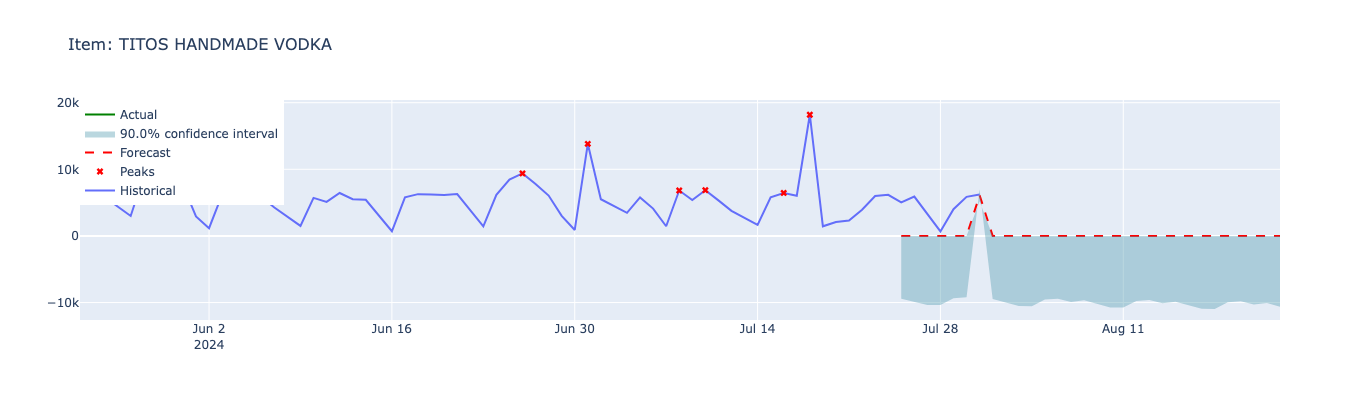

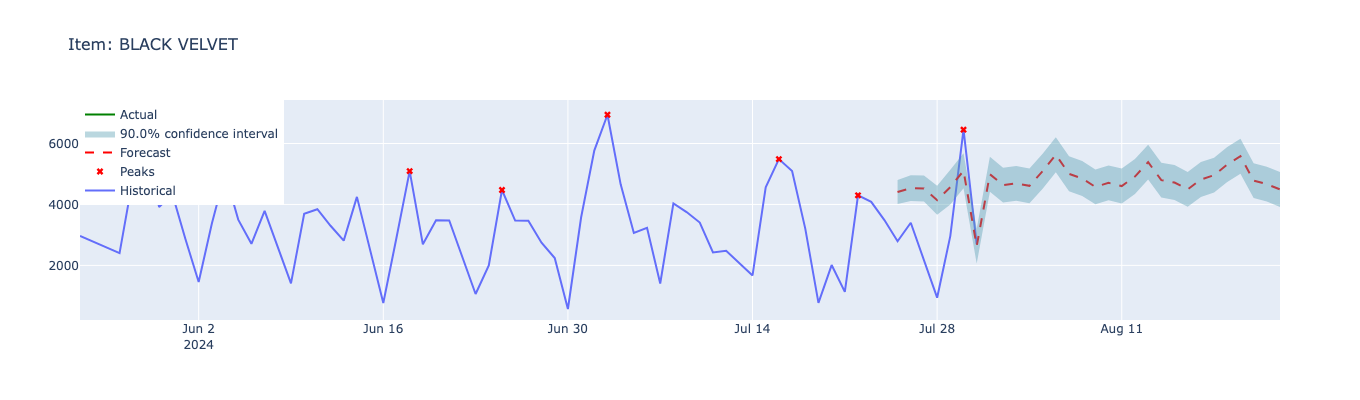

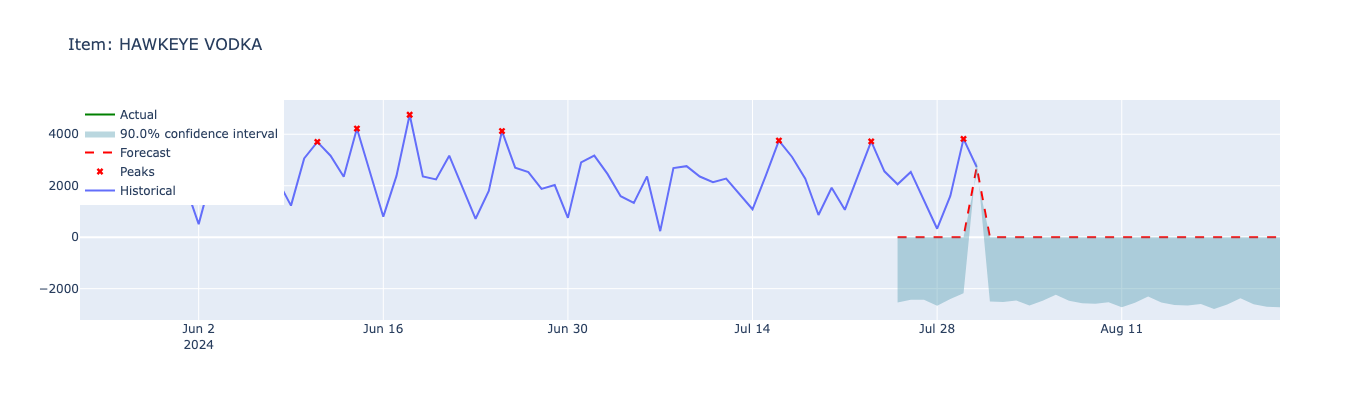

In [193]:
forecast_dict = multi_evaluate_predictions(
    client,
    items_list[:4],
    confidence_level=0.9,
    horizon=HORIZON,
    forecast_table_name=f"{PROJECT_ID}.{DATASET_NAME}.future_forecast_data",
)
for item_name, forecast_info in forecast_dict.items():
    training_df = forecast_info["train_df"].sort_values("date").assign(
        **{
            "forecast_value": 0,
            "prediction_interval_lower_bound": 0,
            "prediction_interval_upper_bound": 0,
            "confidence_level": 0,
            "time_series_type": "history",
        }
    )
    predictions_df = forecast_info["eval_df"].sort_values("date").assign(
        **{"time_series_type": "forecast"}
    )
    items_predictions = [*items_predictions, training_df, predictions_df]
    plot_historical_and_forecast(
        input_timeseries=training_df,
        timestamp_col_name="date",
        data_col_name="total_amount_sold",
        forecast_output=predictions_df,
        actual=predictions_df,
        title=f"Item: {item_name}",
        plotstartdate=(pd.to_datetime(END_DATE) - pd.DateOffset(months=2)).strftime("%Y-%m-%d"),
        prop={'size': 12},
        engine="plotly",
    )

items_predictions_df = (
    pd.concat(items_predictions, ignore_index=True)
    .sort_values(["item_name", "date"])
)
items_predictions_df = items_predictions_df.fillna(0).astype(
    {
        col: str for col in
        items_predictions_df.select_dtypes(include=object).columns
    }
)
create_bigquery_table_from_pandas(
    client,
    items_predictions_df,
    "predictions_table",
    DATASET_NAME,
)